# Multi-Arm Bandit Pair Solutions

## Question 1
Fill in the code stubs in `banditstrategy.py`

### Epsilon-Greedy
* **Explore** with some probability $\epsilon$ (often 10%)
* All other times we will **exploit** (i.e. choose the bandit with the best performance so far)
* After we choose a given bandit we update the performance based on the result.

```python
class EpsilonGreedyStrategy(Strategy):
    """
    Pick a bandit randomly with equal probability at with probability epsilon.
    Otherwise pick the bandit with the best observed proportion of winning.
    """
    def __init__(self,
                 bandits: list,
                 seed: Optional[int]=None,
                 epsilon: float=0.1) -> None:
        self.epsilon = epsilon
        super().__init__(bandits, seed)

    def choose(self) -> int:
        """Return the index of the selected bandit."""
        if np.random.random() < self.epsilon:
            return np.random.randint(0, len(self._bandits))
        else:
            return self.best()
```

### Softmax
For the softmax algorithm we will choose the bandit randomly in proportion to its estimated value.  For example, the proportion that bandit $A$ is chosen out of bandits $A$, $B$, and $C$ is given by...

$$\frac{e^{p_A/\tau}}{e^{p_A/\tau} + e^{p_B/\tau} + e^{p_C/\tau}}$$

$\tau$ is a choosen parameter that controls the 'randomness' of the choice, usually around 0.001

**NOTE**: Setting $\tau$ at 0.001 will cause an underflow error!  Thus the default is set to 0.01

```python
class SoftmaxStrategy(Strategy):
    """Pick an bandit according to the Boltzman distribution"""
    def __init__(self,
                 bandits: list,
                 seed: Optional[int]=None,
                 tau: float=0.01) -> None:
        self.tau = tau
        super().__init__(bandits, seed)

    def choose(self) -> int:
        """Return the index of the selected bandit."""

        # try each one at least once, to avoid nans
        if self.scores.trials.min() == 0:
            return self.scores.trials.idxmin()

        probs = np.exp(self.scores.wins / self.scores.trials / self.tau)
        probs /= probs.sum()
        return np.random.choice(range(0, len(self._bandits)), p=probs)

```

### UCB1 (Upper Confidence Bound)
For the UCB1 algorithm we will choose whichever bandit that has the largest value.  The value associated with bandit $A$ would be given by...

$$p_A + \sqrt{\frac{2 log N}{n_A}}$$

* $p_A$ = the conversion rate of bandit $A$
* $n_A$ = number of times bandit $A$ has been played
* $N$ = total number of times any bandit has been played

```python
class UCB1Strategy(Strategy):
    """Pick the bandit with the highest Upper Confidence Bound."""
    def _ucb(self) -> pd.Series:
        confidence_bounds = np.sqrt(2 *
                                    np.log(self.scores.trials.sum()) /
                                    self.scores.trials)
        ucb = self.scores.wins / self.scores.trials + confidence_bounds
        return ucb

    def choose(self) -> int:
        """Return the index of the selected bandit."""

        # try each one at least onces, to avoid nans
        if self.scores.trials.min() == 0:
            return self.scores.trials.idxmin()

        return self._ucb().idxmax()
```

### Bayesian Bandit
The Bayesian bandit algorithm involves modeling each of our bandits with a beta distribution with the following shape parameters:

* $\alpha$ = 1 + number of times bandit has won
* $\beta$ = 1 + number of times bandit has lost

We will then take a random sample from each bandit's distribution and choose the bandit with the highest value.

```python
class BayesianStrategy(Strategy):
    """Pick a bandit randomly choosed from the bayesian estimatiion
    of the probabilities."""
    def choose(self) -> int:
        """Return the index of the selected bandit."""
        samples = scs.beta(self.scores.wins + 1,
                           self.scores.trials - scores.wins + 1).rvs()

        return np.argmax(samples)

```

## Question 2

See how many wins you have of the 1000 trials using each of the six strategies (two already implemented) with the starting bandits given above.

Try running it again with all of these values and see how different each algorithm does with respect to total number of wins in 1000 rounds.

```
[0.1, 0.1, 0.1, 0.1, 0.9]
[0.1, 0.1, 0.1, 0.1, 0.12]
[0.1, 0.2, 0.3, 0.4, 0.5]
```

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from bandit import Bandit
import banditstrategy
# Make plots look nice
plt.style.use('ggplot')

In [2]:
def sample_bandits(bandit_probs, choice_funcs, num_trials=1000, seed=42):
    ''' Sample bandits a give number of times with every choice function
    Print out the resulting number of wins for each choice strategy

    Parameters
    -----------
    bandit_probs : Array of floats (0 to 1)
        Indicates the underlying bandit probabilites
    strategies : Array or List of classes
        class object indicating bandit to create
    num_trials : int (default=1000)
        Number of trials to conduct
    seed : int or None (default=42)
        Number to seed our BanditStrategy with for reproducibility
    '''
    print('True Bandit Probabilities: {}'.format(bandit_probs))
    for strategy in strategies:
        bandits = [Bandit(p) for p in bandit_probs]
        strat = strategy(bandits, seed=seed)
        strat.sample(num_trials)
        print("\t{} wins with {}".format(strat.scores.wins.sum(), str(type(strat))[23:-10]))
    print('\n')

This `sample_bandits` function makes it easy for us to quickly sample a given list of choice functions against a list of bandit probabilities.  This function also allows you to easily alter the number of trials (`num_trials`) as well as the random seed (`seed`) for reproducibility 

In [3]:
bandit_probs = [[0.1, 0.1, 0.1, 0.1, 0.9],
                [0.1, 0.1, 0.1, 0.1, 0.12],
                [0.1, 0.2, 0.3, 0.4, 0.5]]
strategies = [banditstrategy.GreedyStrategy,
              banditstrategy.RandomStrategy,
              banditstrategy.EpsilonGreedyStrategy,
              banditstrategy.SoftmaxStrategy,
              banditstrategy.UCB1Strategy,
              banditstrategy.BayesianStrategy]

for probs in bandit_probs:
    sample_bandits(probs, strategies)

True Bandit Probabilities: [0.1, 0.1, 0.1, 0.1, 0.9]
	898.0 wins with Greedy
	263.0 wins with Random
	842.0 wins with EpsilonGreedy
	888.0 wins with Softmax
	835.0 wins with UCB1
	878.0 wins with Bayesian


True Bandit Probabilities: [0.1, 0.1, 0.1, 0.1, 0.12]
	118.0 wins with Greedy
	96.0 wins with Random
	102.0 wins with EpsilonGreedy
	90.0 wins with Softmax
	92.0 wins with UCB1
	99.0 wins with Bayesian


True Bandit Probabilities: [0.1, 0.2, 0.3, 0.4, 0.5]
	508.0 wins with Greedy
	309.0 wins with Random
	471.0 wins with EpsilonGreedy
	367.0 wins with Softmax
	377.0 wins with UCB1
	429.0 wins with Bayesian




## Question 3

Use matplotlib to plot the total regret over time of each algorithm. Use the Bandits with these hidden probabilities: `[0.05, 0.03, 0.06]`

In [4]:
def plot_regret(bandit_probs, strategies, num_trials=1000, seed=42):
    ''' Plots the cumulative regret for each choice function on single plot

    Parameters
    -----------
    bandit_probs : Array of floats (0 to 1)
        Indicates the underlying bandit probabilites
    strategies : Array or List of classes
        class object indicating bandit to create
    num_trials : int (default=1000)
        Number of trials to conduct
    seed : int or None (default=42)
        Number to seed our BanditStrategy with for reproducibility

    Returns
    --------
    None
    Use plt.show() to view the resulting plot or plt.savefig() to save the plot
    '''
    # Create our figure object and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    for strategy in strategies:
        bandits = [Bandit(p) for p in bandit_probs]
        strat = strategy(bandits, seed=seed)
        strat.sample(num_trials)
        bandit_regret = strat.regret()
        ax.plot(bandit_regret, label=str(type(strat))[23:-10])

    ax.legend(loc='best')
    ax.set_xlabel('Number of Trials')
    ax.set_ylabel('Regret')
    ax.set_title('Probabilities: {}, Seed: {}'.format(str(bandit_probs), seed))

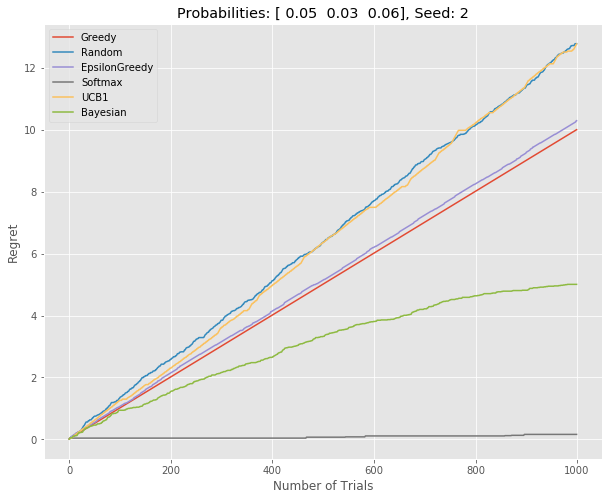

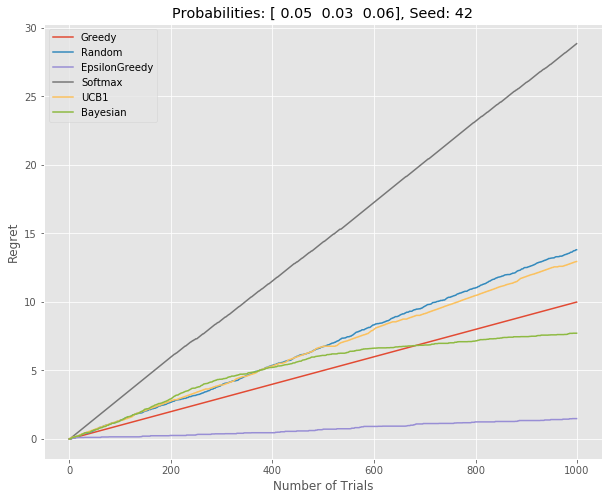

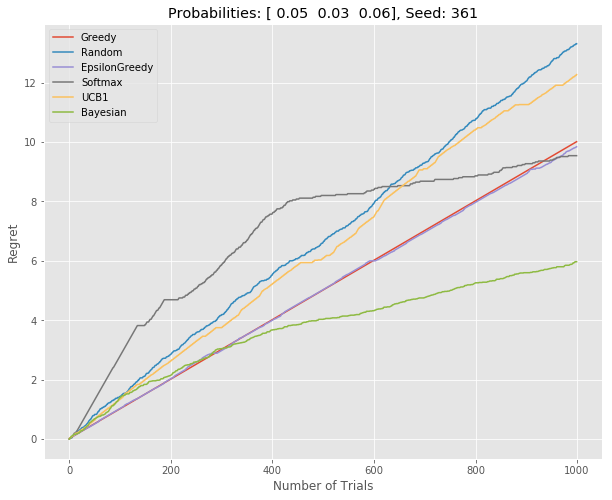

In [5]:
p_array = np.array([0.05, 0.03, 0.06])

# Let's try with a variety of random seeds
seeds = [2, 42, 361]
for seed in seeds:
    plot_regret(p_array, strategies, seed=seed)

As we can see above, the regret of a given choice function can be **heavily** influenced by the random seed that has been set.

## Question 4

Now plot the percentage of time the optimal bandit was chosen over time.

In [6]:
def optimal_percent(probabilities, choices):
    ''' Calculate the percentage of optimal bandit choice over each iteration

    Parameters
    -----------
    probabilities : Array of floats (0 to 1)
        Indicating the underlying bandit probabilites
    choices : Array of int
        ints indicating which bandit was chosen at each round

    Returns
    --------
    Array of floats (0 to 1) indicating the percentage of optimal choice at any
        given choice iteration
    '''
    p_opt = np.max(probabilities)
    count_correct = np.cumsum(probabilities[choices] == p_opt)
    # Divide by the array [1, 2, ...] to get the average from the totals
    return count_correct / np.arange(1, len(choices) + 1).astype(float)


def plot_optimal_percent(bandit_probs, strategies, num_trials=1000, seed=42):
    '''
    Plots the percentage of optimal bandit choice for each choice function on
    single plot

    Parameters
    -----------
    bandit_probs : Array of floats (0 to 1)
        Indicates the underlying bandit probabilites
    choice_funcs : Array or List of str
        str indicating which choice functions to simulate
    num_trials : int (default=1000)
        Number of trials to conduct
    seed : int or None (default=42)
        Number to seed our BanditStrategy with for reproducibility

    Returns
    --------
    None
    Use plt.show() to view the resulting plot or plt.savefig() to save the plot
    '''
    # Create our figure object and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    for strategy in strategies:
        bandits = [Bandit(p) for p in bandit_probs]
        strat = strategy(bandits, seed=seed)
        strat.sample(num_trials)
        bandit_opt = optimal_percent(bandit_probs, strat._choices)
        ax.plot(bandit_opt, label=str(type(strat))[23:-10])

    ax.legend(loc='best')
    ax.set_xlabel('Number of Trials')
    ax.set_ylabel('Percent Correct')
    ax.set_title('Probabilities: {}, Seed: {}'.format(str(bandit_probs), seed))

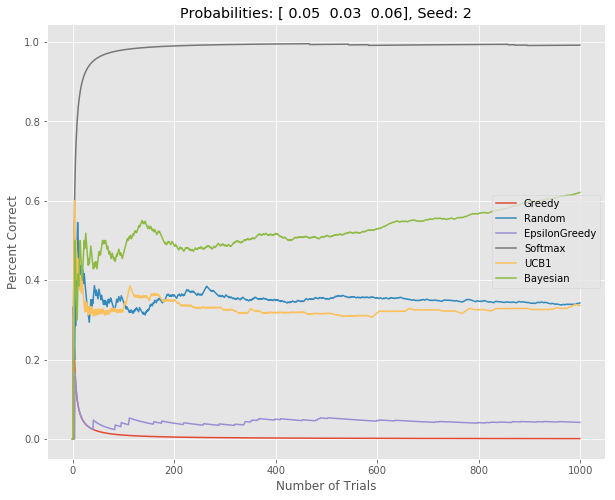

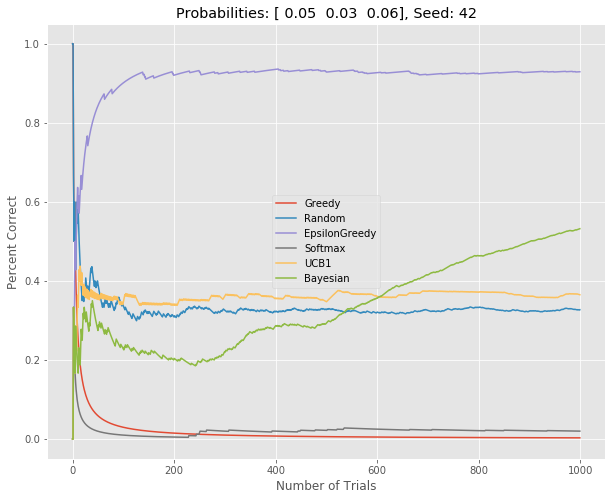

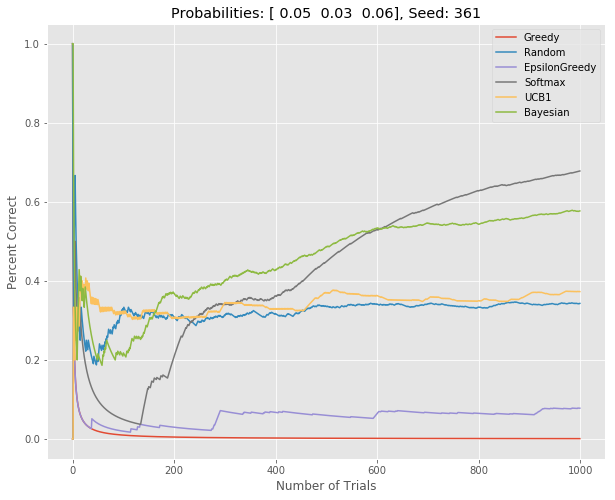

In [7]:
# Let's again plot using a variety of random seeds
for seed in seeds:
    plot_optimal_percent(p_array, strategies, seed=seed)

Because we chose the same 3 random seeds, these plots of how often we chose the optimal bandit for a given choice function coorespond with the plots above showing the regret of each choice function.